# Fitting a model to data with intrinsic scatter or underestimated uncertainties

_Inspired by [Hogg et al. 2010](https://arxiv.org/abs/1008.4686) and [@jakevdp's notes](https://github.com/jakevdp/ESAC-stats-2014)_.

Python imports we'll need later...

In [146]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook')
%matplotlib inline
rnd = np.random.RandomState(seed=42)

---

## First, the simpler case: fitting a straight line to data

### Intro and choice of objective function

I want to start with a problem that everyone is probably familiar with or has at least seen before. The problem is this: we observe $N$ independent data points $\boldsymbol{y}=\{y_1,y_2,...y_N\}$ with uncertainties $\boldsymbol{\sigma}=\{\sigma_1,\sigma_2,...\sigma_N\}$ at perfectly-measured values $\boldsymbol{x}=\{x_1,x_2,...x_N\}$. We have reason to believe that the these data were generated by a process that is well-represented by a straight-line, and the only reason that the data deviate from this straight line is because of uncorrelated, Gaussian measurement noise in the $y$-direction. Let's first generate some data that meet these qualifications:

In [147]:
n_data = 16 # number of data points
a_true = 1.255 # randomly chosen truth
b_true = 4.507 

In [148]:
# randomly generate some x values over some domain by sampling from a uniform distribution
x = rnd.uniform(0, 2., n_data)
x.sort() # sort the values in place

# evaluate the true model at the given x values
y = a_true*x + b_true

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = rnd.uniform(0.1, 0.2, size=n_data) # randomly generate uncertainty for each datum
y = rnd.normal(y, y_err) # re-sample y data with noise

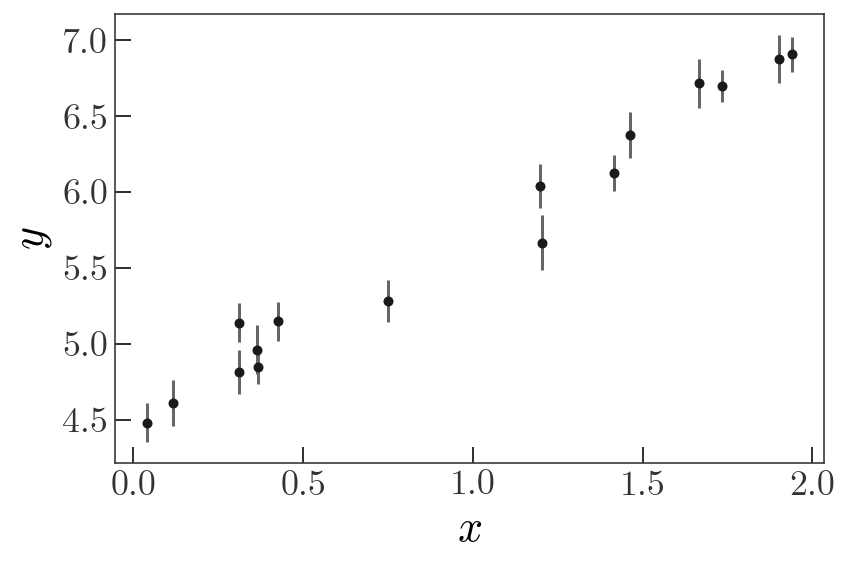

In [149]:
plt.errorbar(x, y, y_err, linestyle='none', marker='o', ecolor='#666666')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

Now let's forget that we did that -- we know nothing about the model parameters, except that we think the true values of the data are well-described by a linear relation! We would like to measure the "best-fit" parameters of this model (for a straight line, the slope and intercept $(a,b)$) given the data above. In math, our model for the data $y$ is:
$$
\begin{align}
y &= f(x \,;\, a, b) + {\rm noise}\\
f(x \,;\, a, b) &= a\,x + b
\end{align}
$$

For a given set of parameters, $(a,b)$, we can evaluate our model $f(x \,;\, a, b)$ at a given $x$ location to compute the value of $y$ that we would expect in the absence of noise. For example, for the $n$th datum and for a given set of parameter values $(a,b)$:

$$
\tilde{y}_n = f(x_n \,;\, a, b)
$$

Now, we somehow want to search through all possible values of $a,b$ to find the "best" values, given the data, with some definition of "best." When we say this word, we are implying that we want to _optimize_ (find the maximum or minimum) some _objective function_ (a function that takes our data, our model, and returns a quantification of "best", usually as a scalar). Numerically, this scalar objective function can be any function (though you probably want it to be convex) and you will see different choices in practice. You have some leeway in this choice depending on whether your goal is _prediction_, _discovery_, _data compression_, or _discovery_. 

However, for _inference_&mdash;the typical use-case for us as scientists&mdash;you don't have this freedom: one of the conclusions of this talk is going to be that __you have no choice about what "best" means__! Before we get there, though, let's explore what seem like reasonable choices. 

Here are a few desirable features we'd like any objective function to have:

1. For a given set of parameters, we should compare our predicted values to the measured values and base our objective function on the differences
2. The scalar value should be dimensionless (the value of the objective function shouldn't care if we use kilometers vs. parsecs)
3. Data points that have larger errors should contribute less to the objective function (if a datum has a large offset from the predicted value, it shouldn't matter _if_ the datum has a large uncertainty)
4. Convexity

To meet these three criteria, whatever objective function we choose should operate on the (dimensionless) quantities:

$$
\chi_n = \frac{y_n - \tilde{y}_n}{\sigma_n}
$$

i.e. the difference between our predicted values $\tilde{y}$ and the observed $y$ values, weighted by the inverse uncertainties $\sigma$. The uncertainties have the same units as the data, so this is a dimensionless quantity. It also has the nice property that, as we wanted, points with large uncertainties are _downweighted_ relative to points with small uncertainties. Here are some ideas for objective functions based on this scalar:

- __Weighted absolute deviation__: the sum of the absolute values

    $\sum_n^N \, \left|\chi_n\right|$
    
    
- __Weighted squared deviation__: the sum of the squares

    $\sum_n^N \, \chi_n^2$
    
    
- __Weighted absolute deviation to some power__ $p$: 

    $\sum_n^N \, \left|\chi_n\right|^p $
    
    
_(Note: don't show this to statisticians or they will get me fired. To a statistician, $\chi^2$ is a distribution not a statistic...but astronomers seem to use this terminology.)_

All of these functions are convex and so we can pass them in to a naive optimizer to find the best parameters. Let's first implement the functions, and then pass them in to the default `scipy.optimize` function minimizer:

In [150]:
# 'pars' stands for parameters and, in this case, will be a length-2 iterable 
# x, y, and y_err should all be numpy arrays when passed in

def model(pars, x):
    return pars[0]*x + pars[1]

def weighted_absolute_deviation(pars, x, y, y_err):
    chi = (y-model(pars, x)) / y_err
    return np.sum(np.abs(chi))

def weighted_power_deviation(pars, p, x, y, y_err):
    chi = (y-model(pars, x)) / y_err
    return np.sum(chi**p)

def weighted_squared_deviation(pars, x, y, y_err):
    return weighted_power_deviation(pars, 2, x, y, y_err)

For simplicity, let's just compare the two most common -- the absolute deviation and the squared deviation. We can demonstrate that these are convex (over some domain) by computing the objective function values over a grid of parameter values (a grid in $a, b$):

In [151]:
# make a 256x256 grid of parameter values centered on the true values
a_grid = np.linspace(a_true-2., a_true+2, 256)
b_grid = np.linspace(b_true-2., b_true+2, 256)
a_grid,b_grid = np.meshgrid(a_grid, b_grid)
ab_grid = np.vstack((a_grid.ravel(), b_grid.ravel())).T

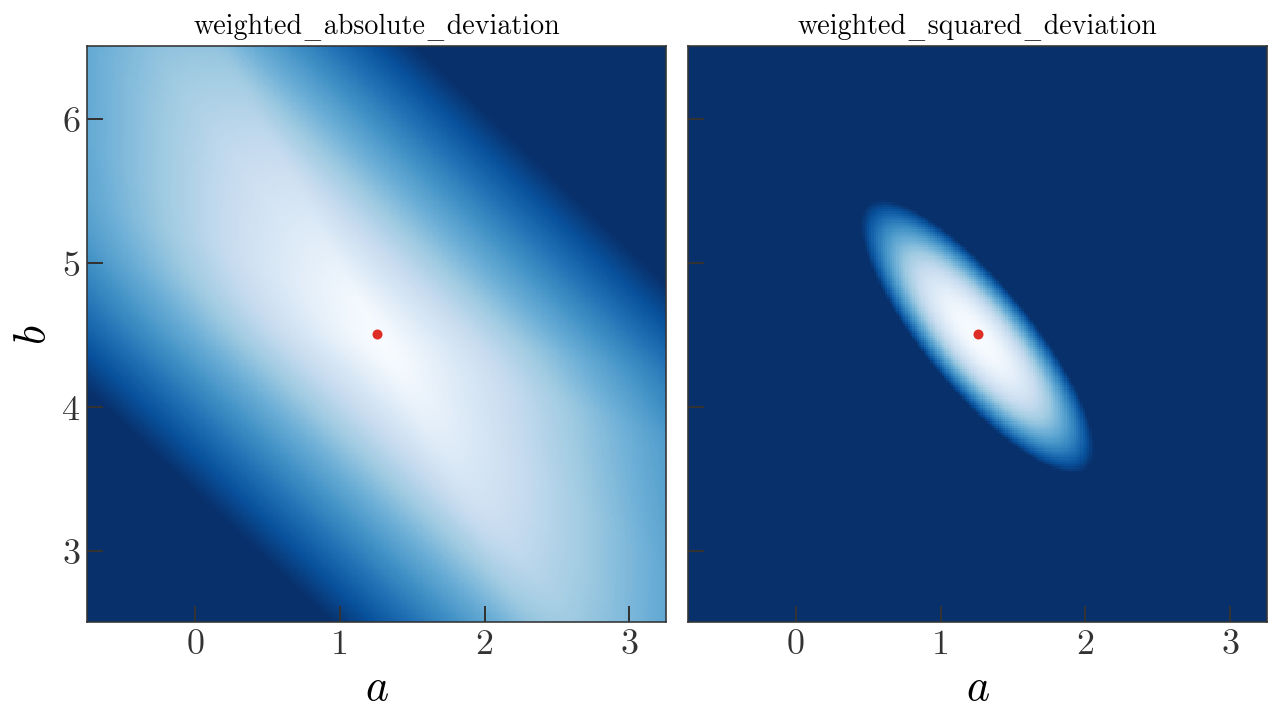

In [152]:
fig,axes = plt.subplots(1, 2, figsize=(9,5.1), sharex=True, sharey=True)

for i,func in enumerate([weighted_absolute_deviation, weighted_squared_deviation]):
    func_vals = np.zeros(ab_grid.shape[0])
    for j,pars in enumerate(ab_grid):
        func_vals[j] = func(pars, x, y, y_err)

    axes[i].pcolormesh(a_grid, b_grid, func_vals.reshape(a_grid.shape), 
                       cmap='Blues', vmin=func_vals.min(), vmax=func_vals.min()+256) # arbitrary scale
    
    axes[i].set_xlabel('$a$')
    
    # plot the truth
    axes[i].plot(a_true, b_true, marker='o', zorder=10, color='#de2d26')
    axes[i].axis('tight')
    axes[i].set_title(func.__name__, fontsize=14)

axes[0].set_ylabel('$b$')

fig.tight_layout()

There are minima in both cases near the true values of the parameters (good), but the gradient of the function is clearly different (the color scales are the same in each panel above). Let's see what happens when we minimize these objective functions to get the best-fit parameter values:

In [153]:
from scipy.optimize import minimize

In [154]:
x0 = [1., 1.] # starting guess for the optimizer 
result_abs = minimize(weighted_absolute_deviation, x0=x0, args=(x, y, y_err), method='powell')
result_sq = minimize(weighted_squared_deviation, x0=x0, args=(x, y, y_err), method='powell')

best_pars_abs = result_abs.x
best_pars_sq = result_sq.x

Let's now plot our two best-fit lines over the data:

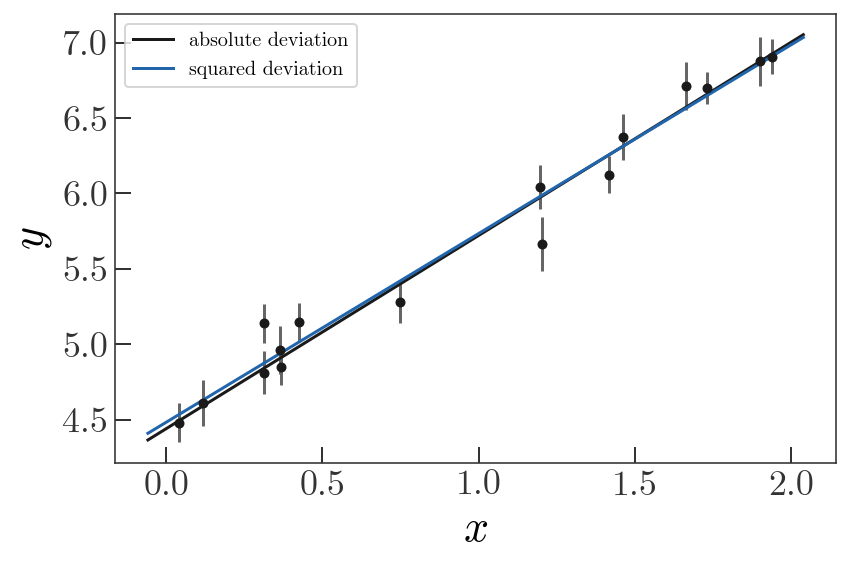

In [155]:
plt.errorbar(x, y, y_err, linestyle='none', marker='o', ecolor='#666666')

x_grid = np.linspace(x.min()-0.1, x.max()+0.1, 128)
plt.plot(x_grid, model(best_pars_abs, x_grid), marker='', linestyle='-', label='absolute deviation')
plt.plot(x_grid, model(best_pars_sq, x_grid), marker='', linestyle='-', label='squared deviation')

plt.xlabel('$x$')
plt.ylabel('$y$')

plt.legend(loc='best')
plt.tight_layout()

Well, by eye they both look reasonable! Are we done?! Not quite -- how do we choose between the two?!

In order to pick between these two, or any of the arbitrary objective functions we could have chosen, we have to _justify_ using one function over the others. In what follows, we'll justify optimizing the sum of the squared deviations (so-called "least-squares fitting") by thinking about the problem _probabilistically_, rather than procedurally.

### Least-squares fitting

Let's review the assumptions we made above in generating our data:

1. The data were generated by a straight line
2. Uncorrelated, _known_ Gaussian uncertainties in $y$ cause deviations between the data and predictions
3. The data points are independent
4. The $x$ data are known perfectly, or at least their uncertainties are _far smaller_ than the uncertainties in $y$

First off, these assumptions tell us that for each datum $(x_n, y_n)$ there is some true $y_{n,{\rm true}}$, and because of limitations in our observing process we can't observe the truth, but we know that the values we do observe will be Gaussian (Normal) distributed around the true value. _(Note: This assumption tends to be a good or at least a conservative approximation in practice, but there are certainly more complex situations when, e.g., you have asymmetric uncertainties, or error distributions with large tails!)_. In math:

$$
\begin{align}
p(y \,|\, y_{\rm true}) &= \mathcal{N}(y \,|\, y_{\rm true}, \sigma^2) \\
\mathcal{N}(y \,|\, y_{\rm true}, \sigma^2) &= (2\pi \sigma^2)^{-1/2} \, \exp\left(-\frac{1}{2} \frac{(y-y_{\rm true})^2}{\sigma^2} \right)
\end{align}
$$

This is the likelihood of observing a particular $y$ given the true $y_{\rm true}$. Note that in our model, all of the $y_{\rm true}$'s must lie on a line. It is also interesting that the argument of the normal distribution looks a lot like $\chi^2$!

What about considering two data points, $y_1$ and $y_2$? Now we need to write down the _joint_ probability

$$
p(y_1, y_2 \,|\, y_{1,{\rm true}}, \sigma_1, y_{2,{\rm true}}, \sigma_2)
$$

But, note that in assumption 3 above, we are assuming the data are independent. In that case, the random error in one point does not affect the random error in any other point, so the joint probability can be turned into a product:

$$
p(\{y_n\} \,|\, \{y_{n,{\rm true}}\}, \{\sigma_n\}) = \prod_n^N \, p(y_n \,|\, y_{n,{\rm true}}, \sigma_n)
$$

This is the full expression for the likelihood of the observed data given the true $y$ values. Recall that these true values, according to our assumptions, must lie on a line with some parameters, and we're trying to infer those parameters! We can compute a particular $y_{n,{\rm true}}$ using $x_n$ and a given set of model parameters $a, b$. With that in mind, we can write the likelihood instead as:

$$
p(\{y_n\} \,|\, a, b, \{x_n\}, \{\sigma_n\}) = \prod_n^N \, p(y_n \,|\, a, b, x_n, \sigma_n)
$$

So what are the "best" values of the parameters $a, b$? They are the ones that _maximize_ this likelihood! 

The product on the right of the likelihood is a product over exponentials (well, Gaussians), which can be annoying to deal with. But, maximizing the likelihood is equivalent to maximizing the _log_-likelihood -- so we can get rid of the product and all of those exponentials by taking the log of both sides:

$$
\begin{align}
\ln p(\{y_n\} \,|\, a, b, \{x_n\}, \{\sigma_n\}) &= \sum_n^N \, \ln p(y_n \,|\, a, b, x_n, \sigma_n) \\
&= \sum_n^N \ln \left[(2\pi \sigma_n^2)^{-1/2} \, 
    \exp\left(-\frac{1}{2} \frac{(y-(a\,x_n+b))^2}{\sigma_n^2} \right) \right] \\
&= -\frac{N}{2}\ln(2\pi) 
    - \frac{1}{2} \sum_n^N \left[\frac{(y-(a\,x_n+b))^2}{\sigma_n^2} + \ln{\sigma_n^2} \right]
\end{align}
$$

In this case, the uncertainties are known and constant, so to maximize this expression we only care that (abbreviating the likelihood as $\mathcal{L}$):

$$
\begin{align}
\ln \mathcal{L} &= - \frac{1}{2} \sum_n^N \left[\frac{(y-(a\,x_n+b))^2}{\sigma_n^2}\right] + {\rm const.} \\
&= - \frac{1}{2} \sum_n^N \, \chi_n^2 + {\rm const.} \\
\end{align}
$$

Apparently, _minimizing_ the sum of the weighted squared deviations is equivalent to _maximizing_ the (log) likelihood derived from thinking about the probability of the data! Above, we did that minimization numerically using an iterative solver. That's fine, but (a) it doesn't directly give us the uncertainties on the inferred model parameters, and (b) there is actually an analytic way to solve this problem using linear algebra that is generally _much_ faster!

### Least-squares / maximum likelihood with matrix calculus

Using linear algebra, we can simplify and generalize a lot of the expressions above. In what follows, all vectors are column vectors and are represented by lower-case bold symbols. Matrices are upper-case bold symbols.


We'll start by writing our model as a matrix equation. To do that, we need a way to, for a given set of parameters, compute the set of predicted $y$'s. This is done by defining the parameter vector, $\boldsymbol{\theta}$, and a matrix typically called the _design matrix_, $\boldsymbol{X}$:

$$
\boldsymbol{\theta} = \begin{bmatrix} b \\ a \end{bmatrix} \quad 
\boldsymbol{X} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_N \end{bmatrix}
$$

(note the order of the parameters!). With these definitions, the vector of predicted $y$ values is just

$$
\boldsymbol{y}_{\rm pred} = \boldsymbol{X} \, \boldsymbol{\theta}
$$

so the deviation vector between the prediction and the data is just $(\boldsymbol{y}-\boldsymbol{X} \, \boldsymbol{\theta})$ where

$$
\boldsymbol{y} = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_N \end{bmatrix}
$$

But how do we include the uncertainties? We'll pack the list of uncertainties (variances) into the trace of a 2D, $N \times N$ matrix called the _covariance matrix_. Because we are assuming the uncertainties are independent, the off-diagonal terms are all zero:

$$
\boldsymbol{\Sigma} = \begin{bmatrix} 
\sigma_1^2 & 0 & \dots & 0 \\ 
0 & \sigma_2^2 & \dots & 0 \\ 
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \sigma_N^2 
\end{bmatrix}
$$

With these matrices, we can write the expression for $\chi^2$ (and therefore the log-likelihood) very concisely:

$$
\begin{align}
\chi^2 &= \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)^\mathsf{T} \, 
    \boldsymbol{\Sigma}^{-1} \,
    \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right) \\
\ln\mathcal{L} &= -\frac{1}{2}\left[N\,\ln(2\pi) 
    + \ln|\boldsymbol{\Sigma}|
    + \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)^\mathsf{T} \, 
      \boldsymbol{\Sigma}^{-1} \,
      \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)
\right]
\end{align}
$$

In this form, the terms in the $\chi^2$ have a nice geometric interpretation: This looks like a distance between the data and the model computed with the metric $\boldsymbol{\Sigma}$.

If you solve for the optimum of the log-likelihood function (take the derivative with respect to $\boldsymbol{\theta}$ and set equal to 0), you find that:

$$
\newcommand{\trpo}[1]{{#1}^{\mathsf{T}}}
\newcommand{\bs}[1]{\boldsymbol{#1}}
\bs{\theta}_{\rm best} = \left[\trpo{\bs{X}} \, \bs{\Sigma}^{-1} \, \bs{X}\right]^{-1} \, 
    \trpo{\bs{X}} \, \bs{\Sigma}^{-1} \, \bs{y}
$$

Getting the best-fit parameters just requires a few simple linear algebra operations! As an added bonus, we also get the _uncertainties_ on the parameters. The $2\times2$ covariance matrix for the best-fit parameters is given by the matrix:

$$
\newcommand{\trpo}[1]{{#1}^{\mathsf{T}}}
\newcommand{\bs}[1]{\boldsymbol{#1}}
C = \left[\trpo{\bs{X}} \, \bs{\Sigma}^{-1} \, \bs{X}\right]^{-1}
$$

Instead of using an iterative optimizer like `scipy.optimize.minimize`, let's just write out the linear algebra explicitly and use `numpy.linalg` to solve this for us!

In [156]:
# create matrices and vectors:

# learn this is a magical function - it makes exactly what we want for the design matrix
X = np.vander(x, N=2, increasing=True) 

# you never want to do this in practice because the matrix will just be full of zeros!
#   that's a good way to waste all of your RAM on storing zeros...
Cov = np.diag(y_err**2)
Cinv = np.linalg.inv(Cov) # we need the inverse covariance matrix

X.shape, Cov.shape, y.shape

((16, 2), (16, 16), (16,))

In [157]:
# using the new Python matrix operator
best_pars_linalg = np.linalg.inv(X.T @ Cinv @ X) @ (X.T @ Cinv @ y)

# we can also get the parameter covariance matrix
pars_Cov = np.linalg.inv(X.T @ Cinv @ X)

Let's see how the parameter values compare to what we found using the numerical optimizer (we reversed the order for the linear algebra so we use `[::-1]` to reverse the array):

In [158]:
best_pars_sq - best_pars_linalg[::-1]

array([  6.79044154e-10,  -4.78852513e-10])

They are almost identical! That's good. Now let's look at the covariance matrix of the parameters (the uncertainty in the parameters) and plot the 1 and 2-sigma error ellipses:

In [159]:
# some tricks to get info we need to plot an ellipse, aligned with 
#    the eigenvectors of the covariance matrix
eigval,eigvec = np.linalg.eig(pars_Cov)
angle = np.degrees(np.arctan2(eigvec[1,0], eigvec[0,0]))
w,h = 2*np.sqrt(eigval)

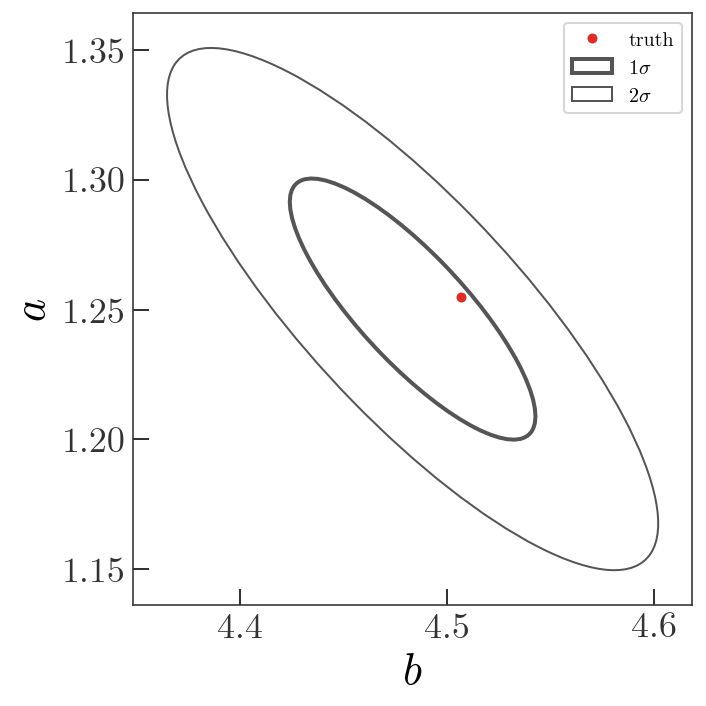

In [160]:
from matplotlib.patches import Ellipse

fig,ax = plt.subplots(1, 1, figsize=(5,5))

for n in [1,2]:
    ax.add_patch(Ellipse(best_pars_linalg, width=n*w, height=n*h, angle=angle, 
                         fill=False, linewidth=3-n, edgecolor='#555555', 
                         label=r'{}$\sigma$'.format(n)))

ax.plot(b_true, a_true, marker='o', zorder=10, linestyle='none',
        color='#de2d26', label='truth')

ax.set_xlabel('$b$')
ax.set_ylabel('$a$')
ax.legend(loc='best')

fig.tight_layout()

## The Bayesian approach

Let's review what we did so far. We found that standard weighted least squares fitting is a justified approach to estimating the best-fit parameters because it optimizes the likelihood of the data under the assumptions of our model; it optimizes a _justified scalar objective function_. We then fit our straight-line model to the data using and got back a point-estimate of the best parameters along with a covariance matrix describing the uncertainties in the parameters. This is the way of the _frequentist_. What we're going to do now is see what happens if we switch to a Bayesian methodology instead. While the two methods end up looking mathematically identical, there are fundamental philosophical differences that can lead to very different interpretations and implementations when models are more complex than the toy example we use above. 

As Bayesians, we aren't interested in a point-estimate of the best parameters, but rather we're interested in the inferred distribution of possible parameter values (the _posterior probability distribution function_ over parameters). So how do we write down or solve for this posterior pdf? Before we get to that, let's take a look at a fundamental equation of Bayesian statistics, [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes'_theorem), which we'll derive using the joint probability of $A$ and $B$ which are conditional on some other information $I$ that, right now, we don't care about. For example, $A$ could be the time it takes to get from here to NYC, $B$ could be the amount of traffic on the road, and $I$ could include the information that we're driving a car and not walking. Bayes' theorem as expressed below is not controversial -- Bayesians and Frequentists agree that this is just how joint and conditional probabilities work. We start by writing down the joint probability of $A$ and $B$, then factor it in two ways into conditional proabilities:

$$
p(A,B \,|\, I) = p(A\,|\,B, I)\,p(B\,|\, I) = p(B\,|\,A, I)\,p(A \,|\, I)
$$

Now we look at the right two expressions, and divide by one of the marginal probabilities to get:

$$
p(A\,|\,B, I) = \frac{p(B\,|\,A, I)\,p(A \,|\, I)}{p(B\,|\, I)}
$$

Ok, so that's all fine. Now let's replace $A$ and $B$ with variables that represent, from our example above, our data $D=(\{x_n\},\{y_n\},\{\sigma_n\})$ and our model parameters $\boldsymbol{\theta}$:

$$
p(\boldsymbol{\theta}\,|\,D, I) = \frac{p(D\,|\,\boldsymbol{\theta}, I)\,p(\boldsymbol{\theta} \,|\, I)}{p(D\,|\, I)}
$$

In just switching the meaning of the variables, this expression becomes controversial! Frequentists would object to the above for two main reasons:

1. The term on the left hand side is a probability over parameters given the data (the _posterior_ pdf) $p(\boldsymbol{\theta}\,|\,D, I)$. This is something that a frequentist would say cannot exist - there is only one true vector of parameters that we are trying to learn, not a distribution!
2. The right-most term in the numerator is a probability over parameters _with no dependence on the data_ (the _prior_ pdf). This encapsulates all of our prior knowledge about the parameters before we did the experiment and observed some data. This is perhaps the aspect of Bayesian inference that frequentists most disagree with. 

The differences above result from the fact that probability means something different to Frequentists and Bayesians. Bayesians think of probability as representing a _degree of belief_ about something, whereas a frequentist thinks of a probability as related to _limiting frequencies of occurrence_ in repeated trials or observations. This is a rich topic and I highly recommend reading [this series of blogposts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake Vanderplas to learn more. For now, let's put on Bayesian hats and take a look at the implications of the expression above.

(_It's good to rememeber that we're all friends. The differences are based on philosophy and so can lead to some heated discussions and debates, but remember we're all trying to do science -- we're on the same team!_)

## Bayes' theorem and Bayesian inference

Let's decompose Bayes' theorem (as applied to modeling and inference). The four terms in Bayes' theorem above have names that are good to be familiar with:

- $p(\boldsymbol{\theta}\,|\,D, I)$ - __posterior probability__:
    This is the thing we are after when we do Bayesian inference or model fitting. We want to know what the distribution of possible parameter values is, given the data we observe and any prior information or assumptions $I$.
    

- $p(D\,|\,\boldsymbol{\theta}, I)$ - __likelihood__:
    This is the likelihood of the data given a particular set of model parameters. We've already seen this object and used it above to find the best-fit model parameters by maximizing this function. In a Bayesian context, it can also be thought of as a distribution -- it's a distribution that generates new datasets given a model instance. For that reason, we typically refer to models that produce a likelihood as _generative models_ because they specify how to  generate new data sets that look like the one you observe. As we saw above when we wrote the likelihood function for a straight line model and data with Gaussian errors, the likelihood usually contains a component that can be interpreted as the _noise model_.


- $p(\boldsymbol{\theta} \,|\, I)$ - __prior probability__
    This contains any relevant information about our parameters that we know before observing the data. This can include physical constraints, previous measurements, or anything, really. This flexibility is what makes the prior a somewhat controversial object. In practice, the prior only really matters if it is much narrower than the likelihood function. If the prior is broad with respect to the likelihood, the information in the likelihood makes the prior almost irrelevant. However, there are several subtleties to choosing priors that need to be considered. As an example, one subtlety comes from the choice of coordinates for the model parameters: a prior that is broad and flat in a parameter $\alpha$ won't be broad and flat if you change variables to $\beta = \alpha^2$. 


- $p(D\,|\, I)$ - __evidence__ or __fully marginalized likelihood__ (FML)
    In many cases the evidence is simply a normalization constant and, for some of the most relevant algorithms used in inference, can be ignored. This term involves an integral over all of parameter space that can be very difficult to compute:
    
    $$
    p(D\,|\, I) = \int \,\mathrm{d}\boldsymbol{\theta} \, p(D\,|\,\boldsymbol{\theta}, I) \, p(\boldsymbol{\theta} \,|\, I)
    $$
    
    If you need to do Bayesian model selection (e.g., decide between models with different parameters), you unfortunately need to compute this quantity. But if you only _think_ you need the FML, beware!

So how do we make use of all of this, in practice? 

Let's return to our example of fitting a line to data with the same data as above. In some sense, we are almost done once we write down an expression for the posterior pdf. If we ignore the FML, this amounts to multiplying a likelihood by a prior pdf. Well, we've already done the most important part: we already wrote down the likelihood function! This is often the hardest part and what we spend the most time doing as scientists (well, assuming you're not building the instrument to observe the data!). We now need to define a prior pdf over the model parameters. Here we have some flexibility. Two possibilities you can always consider:

1. A completely uninformative prior, based on dimensionality, symmetry, or entropy arguments (sometimes, this will mean using a _flat prior_ or _uniform prior_)
2. An empirical prior, based on previous _independent data_ that constrains this model (e.g., a previous measurement of the model parameters from an earlier dataset)

For simplicity, we're going to assume a flat prior over both slope and intercept. Note that for this problem, this is [_not_ an uninformative prior](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). For now, we'll assume that the data are informative enough that the small bias we introduce by using this prior is negligible. Let's now define the functions we'll need, and recall that

$$
\ln\mathcal{L} = -\frac{1}{2}\left[N\,\ln(2\pi) 
    + \ln|\boldsymbol{\Sigma}|
    + \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)^\mathsf{T} \, 
      \boldsymbol{\Sigma}^{-1} \,
      \left(\boldsymbol{y} - \boldsymbol{X}\,\boldsymbol{\theta}\right)
\right]
$$

In [161]:
def ln_likelihood(pars, x, y, y_err):
    """ The likelihood function evaluation requires a particular set of model parameters and the data """
    N = len(y)
    dy = y - model(pars, x)
    ivar = 1/y_err**2 # inverse-variance
    return -0.5 * (N*np.log(2*np.pi) + np.sum(2*np.log(y_err)) + np.sum(dy**2 * ivar))

def ln_prior(pars): 
    """ The prior only depends on the parameters """
    
    a,b = pars
    lp = 0.
    
    # we'll define the prior over slope to be flat (uniform) over the range [0,10]
    # this means the probability is equal to 1/10 within this range, and 0 outside
    # the log of 0 is -infinity
    if a < 0 or a > 10.:
        return -np.inf
    else:
        lp += np.log(0.1) # normalization, log(1/10)
        
    # similarly, we'll use a uniform prior on b over the range [-100, 100]
    if b < -100 or b > 100.:
        return -np.inf
    else:
        lp += np.log(5E-3) # normalization, log(1/200)
        
    return lp

def ln_posterior(p, x, y, y_err):
    """ 
    Up to a normalization constant, the log of the posterior pdf is just 
    the sum of the log likelihood plus the log prior.
    """
    lnp = ln_prior(p)
    if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
        return lnp

    lnL = ln_likelihood(p, x, y, y_err)
    lnprob = lnp + lnL

    if np.isnan(lnprob):
        return -np.inf

    return lnprob

Now we'll repeat what we did above to map out the value of the log-posterior over a 2D grid of parameter values. Because we used a flat prior, you'll notice it looks identical to the visualization of the `weighted_squared_deviation` -- only the likelihood has any slope to it!

In [162]:
def evaluate_on_grid(func, a_grid, b_grid, args=()):
    a_grid,b_grid = np.meshgrid(a_grid, b_grid)
    ab_grid = np.vstack((a_grid.ravel(), b_grid.ravel())).T
    
    func_vals = np.zeros(ab_grid.shape[0])
    for j,pars in enumerate(ab_grid):
        func_vals[j] = func(pars, *args)
        
    return func_vals.reshape(a_grid.shape)

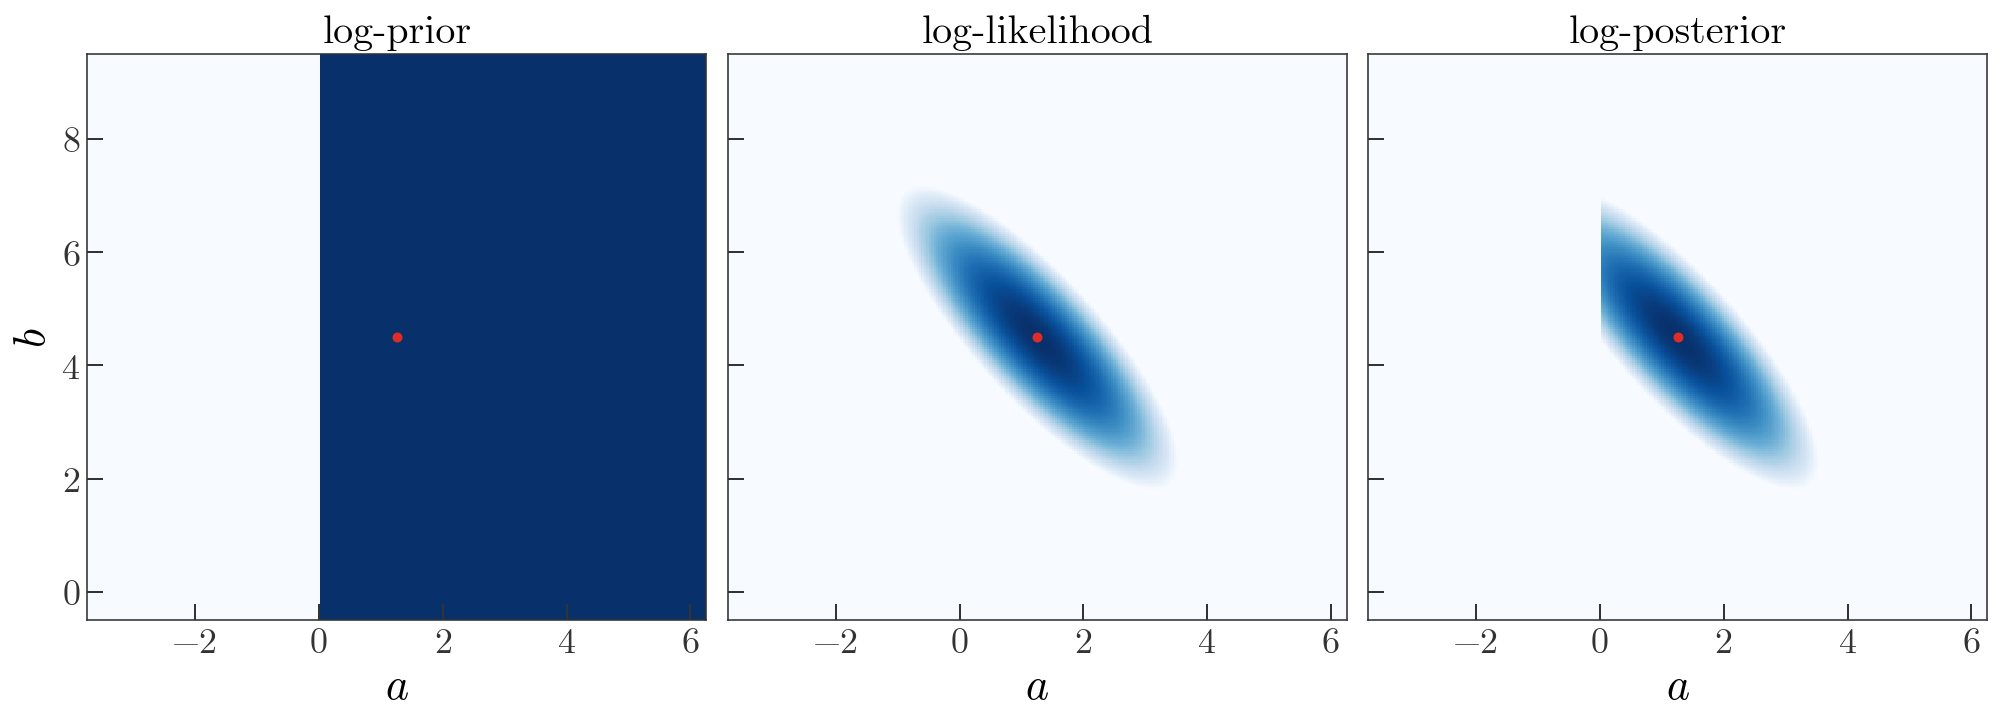

In [163]:
fig,axes = plt.subplots(1, 3, figsize=(14,5.1), sharex=True, sharey=True)

# make a 256x256 grid of parameter values centered on the true values
a_grid = np.linspace(a_true-5., a_true+5, 256)
b_grid = np.linspace(b_true-5., b_true+5, 256)

ln_prior_vals = evaluate_on_grid(ln_prior, a_grid, b_grid)
ln_like_vals = evaluate_on_grid(ln_likelihood, a_grid, b_grid, args=(x, y, y_err))
ln_post_vals = evaluate_on_grid(ln_posterior, a_grid, b_grid, args=(x, y, y_err))

for i,vals in enumerate([ln_prior_vals, ln_like_vals, ln_post_vals]):
    axes[i].pcolormesh(a_grid, b_grid, vals, 
                       cmap='Blues', vmin=vals.max()-1024, vmax=vals.max()) # arbitrary scale
    
axes[0].set_title('log-prior', fontsize=20)
axes[1].set_title('log-likelihood', fontsize=20)
axes[2].set_title('log-posterior', fontsize=20)
    
for ax in axes:
    ax.set_xlabel('$a$')
    
    # plot the truth
    ax.plot(a_true, b_true, marker='o', zorder=10, color='#de2d26')
    ax.axis('tight')

axes[0].set_ylabel('$b$')

fig.tight_layout()

### Exercise: what happens if you use a different prior? 

Replace the flat prior above with an uncorrelated 2D Gaussian centered on $(\mu_a,\mu_b) = (3., 5.5)$ with root-variances $(\sigma_a,\sigma_b) = (0.05, 0.05)$. What happens?

---

Now what do we do? The answer depends a bit on your intentions. If you'd like to propagate the posterior pdf (as in, pass on to other scientists to use your results), what do you do if the posterior pdf isn't analytic? And what numbers do you put in your abstract? One option is to draw samples from your posterior pdf and compute summary statistics (e.g., median and quantils) using the samples. That's the approach we're going to take. One of the most common and powerful class of methods people use for generating these samples is Markov Chain Monte Carlo (MCMC), but there are other options (e.g., brute-force or monte carlo rejection sampling). MCMC methods are useful because they scale reasonably to higher dimensions (well, at least better than brute-force). A disadvantage to these methods comes from the "Markov Chain" part of the name: there is always some correlation between nearby steps in a chain of samples, so you have to compute second-order statistics on the samples to try to verify whether your samples are truly random or fair samples from the target distribution (your posterior pdf).

The simplest MCMC algorithm is known as Metropolis-Hastings. I'm not going to explain it in detail, but in pseudocode, it is:

- Start from some position in parameter space, $\theta_0$ with posterior probability $\pi_0$
- Iterate from 1 to $N_{\rm steps}$:
    - Sample an offset from $\delta\theta_0$ from some proposal distribution
    - Compute a new parameter value using this offset, $\theta_{\rm new} = \theta_0 + \delta\theta_0$
    - Evaluate the posterior probability at the new new parameter vector, $\pi_{\rm new}$
    - Sample a uniform random number, $r \sim \mathcal{U}(0,1)$
    - if $\pi_{\rm new}/\pi_0 > 1$ or $\pi_{\rm new}/\pi_0 > r$:
        - store $\theta_{\rm new}$
        - replace $\theta_0,\pi_0$ with $\theta_{\rm new},\pi_{\rm new}$
    - else:
        - store $\theta_0$ again
        
The proposal distribution has to be chosen and tuned by hand. We'll use a spherical / uncorrelated Gaussian distribution with root-variances set by hand:

In [164]:
def sample_proposal(*sigmas):
    return np.random.normal(0., sigmas)

def run_metropolis_hastings(p0, n_steps, ln_posterior, ln_post_args=(), proposal_args=()):
    """
    Run a Metropolis-Hastings MCMC sampler to generate samples from the input
    log-posterior function, starting from some initial parameter vector.
    
    Parameters
    ----------
    p0 : iterable
        Initial parameter vector.
    n_steps : int
        Number of steps to run the sampler for.
    ln_posterior : callable
        A function or callable that takes a parameter vector and 
        other arguments (passed in through `ln_post_args`) and computes 
        the log of the posterior pdf.
    ln_post_args : iterable (optional)
        A list of arguments passed to the `ln_posterior` function after 
        the parameters.    
    proposal_args : iterable (optional)
        A list of arguments passed to the `sample_proposal` function, used
        to set the parameters of the proposal distribution
    """
    p0 = np.array(p0)
    chain = np.zeros((n_steps, len(p0)))
    ln_probs = np.zeros(n_steps)
    n_accept = 0
    
    ln_probs[0] = ln_posterior(p0, *ln_post_args)
    chain[0] = p0
    for i in range(1,n_steps):
        step = sample_proposal(*proposal_args)
        p = chain[i-1] + step
        
        new_ln_prob = ln_posterior(p, *ln_post_args)
        ln_p_accept = new_ln_prob - ln_probs[i-1]
        if (ln_p_accept > 0) or (ln_p_accept > np.log(np.random.uniform())):
            chain[i] = p
            n_accept += 1
            ln_probs[i] = new_ln_prob
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
    
    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac

Now we'll run the sampler! Let's start from some arbitrary position allowed by our prior:

In [165]:
p0 = [6.,6.]
chain,_,acc_frac = run_metropolis_hastings(p0, n_steps=8192, ln_posterior=ln_posterior, 
                                           ln_post_args=(x,y,y_err), # need to pass the data
                                           proposal_args=(0.05,0.05)) # the root-variances of the proposal distribution
acc_frac

0.4091796875

Let's look at the chain returned, the parameter value positions throughout the sampler run:

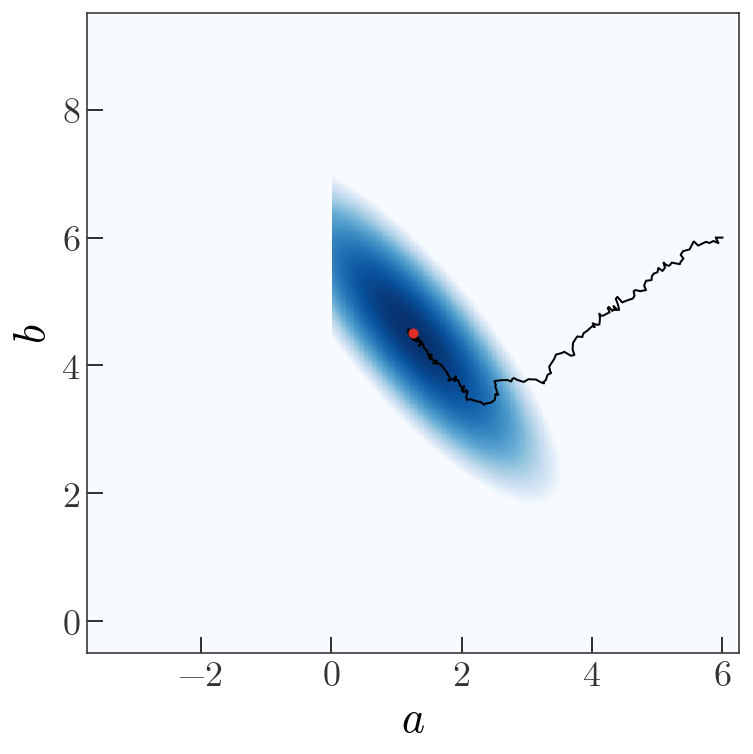

In [166]:
fig,ax = plt.subplots(1, 1, figsize=(5,5))

ax.pcolormesh(a_grid, b_grid, ln_post_vals, 
              cmap='Blues', vmin=vals.max()-1024, vmax=vals.max()) # arbitrary scale
ax.axis('tight')

fig.tight_layout()

ax.plot(a_true, b_true, marker='o', zorder=10, color='#de2d26')
ax.plot(chain[:512,0], chain[:512,1], marker='', color='k', linewidth=1.)

ax.set_xlabel('$a$')
ax.set_ylabel('$b$')

We can also look at the individual parameter traces, i.e. the 1D functions of parameter value vs. step number for each parameter separately:

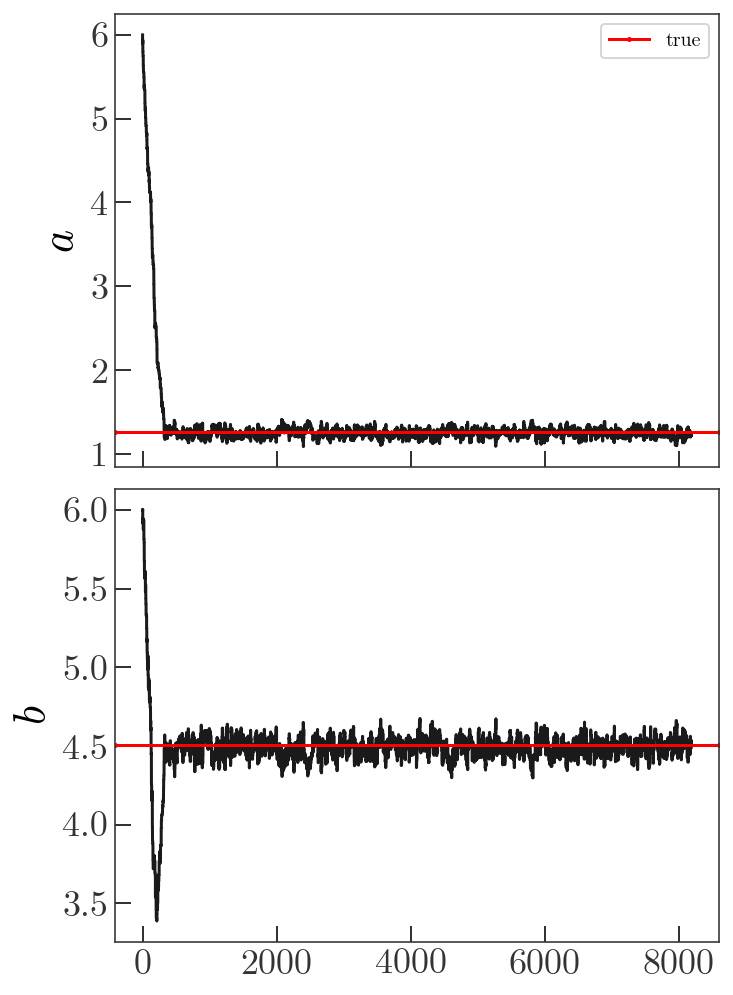

In [167]:
fig,axes = plt.subplots(len(p0), 1, figsize=(5,7), sharex=True)

for i in range(len(p0)):
    axes[i].plot(chain[:,i], marker='', drawstyle='steps')
    
axes[0].axhline(a_true, color='r', label='true')
axes[0].legend(loc='best')
axes[0].set_ylabel('$a$')

axes[1].axhline(b_true, color='r')
axes[1].set_ylabel('$b$')

fig.tight_layout()

From these trace plots, we can see by eye that it takes the sampler about a few hundred steps to converge. When we look at the samples returned or when we compute our summary statistics, we don't want to include these parameter values! In addition, there is likely some correlation between nearby steps. We can attempt to remove some of the correlated steps by _thinning_ the chain, i.e. by downsampling. We can do both simultaneously using Python indexing tricks. Certainly by step 2000 the chains look converged, so from there on we'll keep only every 8th step:

In [168]:
good_samples = chain[2000::8]
good_samples.shape

(774, 2)

We're left with 774 samples; we hope these are approximately uncorrelated, converged samples from the posterior pdf (there are other ways we can check, but these are out of scope for this workshop). Now you have to choose what summary statistics to report. You have some options, but a reasonable choice is to report the median, 16th, and 84th percentiles:

In [169]:
from IPython import display

In [170]:
low,med,hi = np.percentile(good_samples, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str = ""
for i,name in enumerate(['a', 'b']):
    fmt_str = '{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}'
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r'\quad '
    
disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

Recall that the true values are:

In [171]:
a_true, b_true

(1.255, 4.507)

We've now done this problem the Bayesian way as well! Now, instead of drawing the "best-fit" line over the data, we can take a handful of samples and plot a line for each of the samples, as a way to visualize the uncertainty we have in the model parameters:

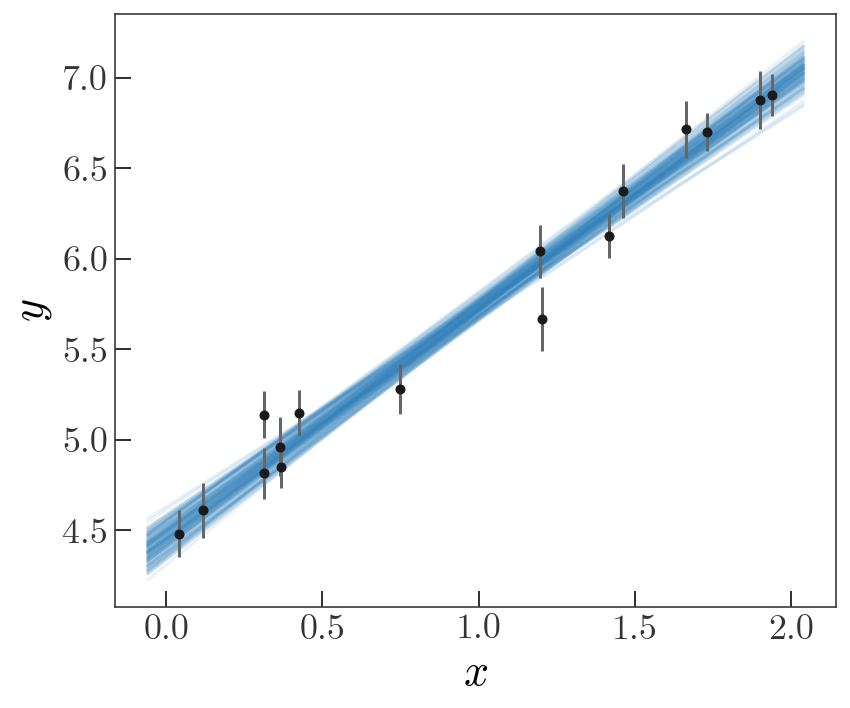

In [172]:
plt.figure(figsize=(6,5))
plt.errorbar(x, y, y_err, linestyle='none', marker='o', ecolor='#666666')

x_grid = np.linspace(x.min()-0.1, x.max()+0.1, 128)
for pars in good_samples[:128]: # only plot 128 samples
    plt.plot(x_grid, model(pars, x_grid), 
             marker='', linestyle='-', color='#3182bd', alpha=0.1, zorder=-10)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

Or, we can plot the samples using a _corner plot_ to visualize the structure of the 2D and 1D (marginal) posteriors:

In [173]:
# uncomment and run this line if the import fails:
# !source activate statsseminar; pip install corner
import corner

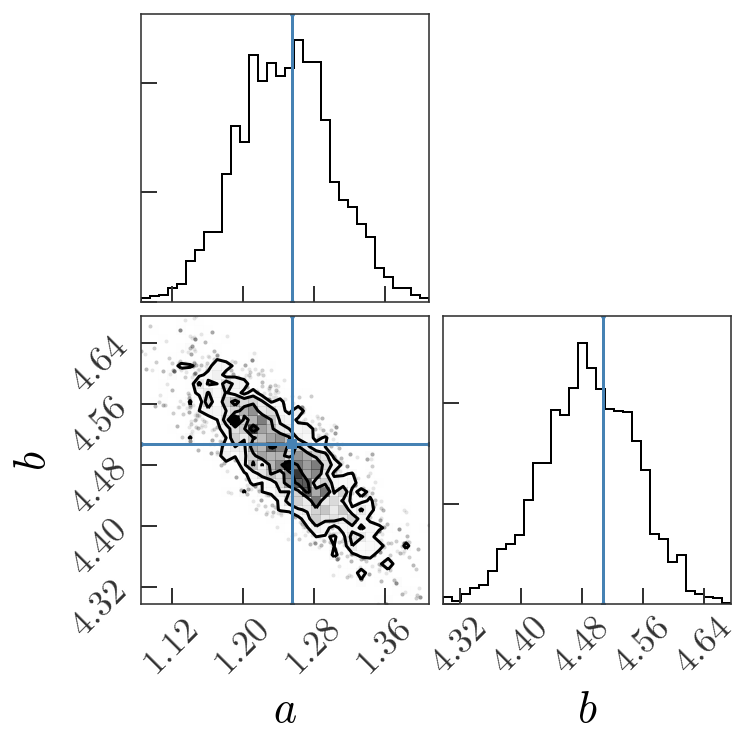

In [174]:
fig = corner.corner(chain[2000:], bins=32, labels=['$a$', '$b$'], truths=[a_true, b_true])

---

## Finally, the problem you came here for: fitting a straight line to data with intrinsic scatter

We made it! We're now ready to do the problem we set out to do. In the initial model, we assumed that we knew the uncertainties in our measurements exactly and that the data were drawn from a one-dimensional line. We're now going to relax that assumption and assume that either (a) the data uncertainties have been underestimated or (b) there is intrinsic scatter in the true model (in the absence of other information, these two ideas are degenerate). Let's first generate some data. We'll assume the latter of the two ideas, and we'll further assume that the model line is convolved with an additional Gaussian in the $y$ direction, with the new parameter being the intrinsic width of the relation expressed as a variance $V$:

In [175]:
V_true = 0.5**2
n_data = 42

# we'll keep the same parameters for the line as we used above

In [176]:
x = rnd.uniform(0, 2., n_data)
x.sort() # sort the values in place

y = a_true*x + b_true

# Heteroscedastic Gaussian uncertainties only in y direction
y_err = rnd.uniform(0.1, 0.2, size=n_data) # randomly generate uncertainty for each datum

# add Gaussian intrinsic width
y = rnd.normal(y, np.sqrt(y_err**2 + V_true)) # re-sample y data with noise and intrinsic scatter

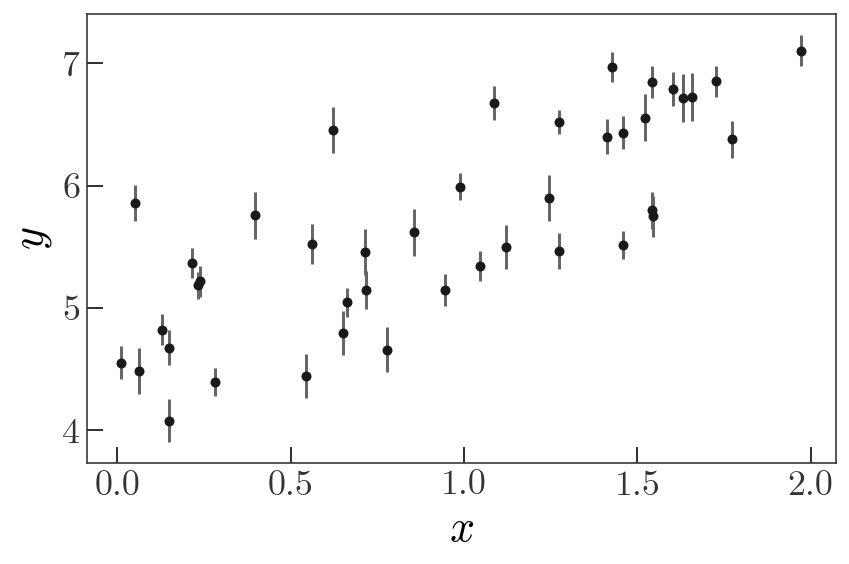

In [177]:
plt.errorbar(x, y, y_err, linestyle='none', marker='o', ecolor='#666666')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()

Let's first naively fit the data assuming no intrinsic scatter using least-squares:

In [178]:
X = np.vander(x, N=2, increasing=True) 
Cov = np.diag(y_err**2)
Cinv = np.linalg.inv(Cov)

In [179]:
best_pars = np.linalg.inv(X.T @ Cinv @ X) @ (X.T @ Cinv @ y)
pars_Cov = np.linalg.inv(X.T @ Cinv @ X)

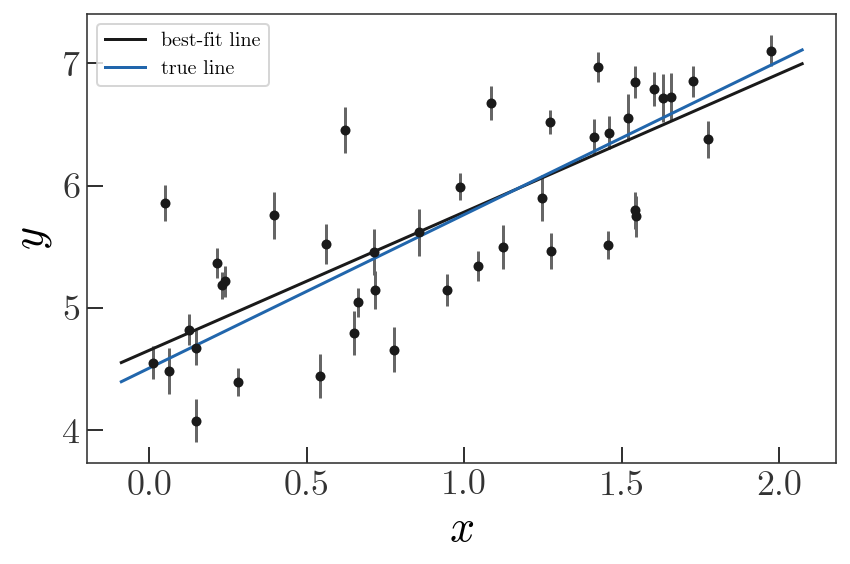

In [180]:
plt.errorbar(x, y, y_err, linestyle='none', marker='o', ecolor='#666666')

x_grid = np.linspace(x.min()-0.1, x.max()+0.1, 128)
plt.plot(x_grid, model(best_pars[::-1], x_grid), marker='', linestyle='-', label='best-fit line')
plt.plot(x_grid, model([a_true, b_true], x_grid), marker='', linestyle='-', label='true line')

plt.xlabel('$x$')
plt.ylabel('$y$')

plt.legend(loc='best')
plt.tight_layout()

The covariance matrix for the parameters is:

In [181]:
pars_Cov

array([[ 0.00173349, -0.00133591],
       [-0.00133591,  0.00143021]])

We clearly get a biased result and yet _very_ precise measurements of the parameters when we don't take in to account the intrinsic scatter. What we need to do now is modify out model to include the scatter as a free parameter. Unfortunately, it enters the model non-linearly so there is no solution using linear algebra or least-squares. Instead, we just write a new likelihood function and optimize it numerically. One choice we'll make is to use the parameter $\ln{V}$ instead of $V$ for reasons I'll explain later:

In [182]:
def ln_likelihood(pars, x, y, y_err):
    """ The likelihood function evaluation requires a particular set of model parameters and the data """
    a,b,lnV = pars
    V = np.exp(lnV)
    
    N = len(y)
    dy = y - model([a,b], x)
    ivar = 1 / (y_err**2 + V) # inverse-variance now includes intrinsic scatter
    return -0.5 * (N*np.log(2*np.pi) - np.sum(np.log(ivar)) + np.sum(dy**2 * ivar))

In [183]:
x0 = [5., 5., 0.] # starting guess for the optimizer 

# we have to minimize the negative log-likelihood to maximize the likelihood
result_ml_scatter = minimize(lambda *args: -ln_likelihood(*args), 
                             x0=x0, args=(x, y, y_err), method='powell')
result_ml_scatter

   direc: array([[ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.1918019 , -0.17687889, -0.11587245]])
     fun: 31.309511152324035
 message: 'Optimization terminated successfully.'
    nfev: 133
     nit: 4
  status: 0
 success: True
       x: array([ 1.12333452,  4.63870739, -1.44626832])

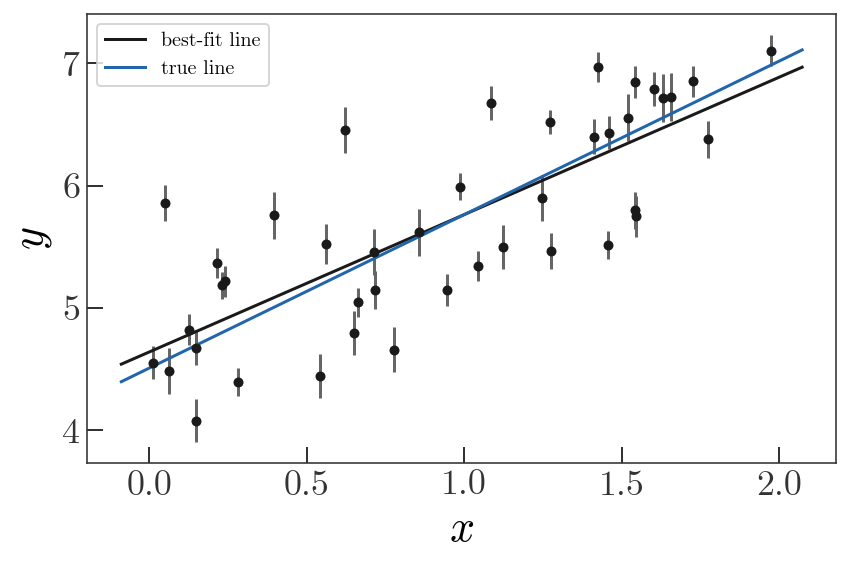

In [184]:
plt.errorbar(x, y, y_err, linestyle='none', marker='o', ecolor='#666666')

x_grid = np.linspace(x.min()-0.1, x.max()+0.1, 128)
plt.plot(x_grid, model(result_ml_scatter.x[:2], x_grid), marker='', linestyle='-', label='best-fit line')
plt.plot(x_grid, model([a_true, b_true], x_grid), marker='', linestyle='-', label='true line')

plt.xlabel('$x$')
plt.ylabel('$y$')

plt.legend(loc='best')
plt.tight_layout()

In [185]:
V_true, np.exp(result_ml_scatter.x[2])

(0.25, 0.23544726559798776)

It looks like the maximum likelihood estimate is a little bit better, and we get a reasonable measurement of the intrinsic scatter, but none of this gives us a handle on the uncertainty. How do we quantify the uncertainty in the now 3 parameters? We'll just run MCMC:

In [186]:
def ln_prior(pars): 
    """ The prior only depends on the parameters """
    
    a, b, lnV = pars
    
    # flat priors on a, b, lnV
    if a < -10 or a > 10 or b < -100. or b > 100. or lnV < -10. or lnV > 10.:
        return -np.inf
    
    # this is only valid up to a numerical constant 
    return 0.

def ln_posterior(p, x, y, y_err):
    """ 
    Up to a normalization constant, the log of the posterior pdf is just 
    the sum of the log likelihood plus the log prior.
    """
    lnp = ln_prior(p)
    if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
        return lnp

    lnL = ln_likelihood(p, x, y, y_err)
    lnprob = lnp + lnL

    if np.isnan(lnprob):
        return -np.inf

    return lnprob

In [187]:
p0 = [6., 6., -1.]
chain,_,acc_frac = run_metropolis_hastings(p0, n_steps=16384, ln_posterior=ln_posterior, 
                                           ln_post_args=(x,y,y_err), 
                                           proposal_args=(0.15,0.15,0.2))
acc_frac

0.3065185546875

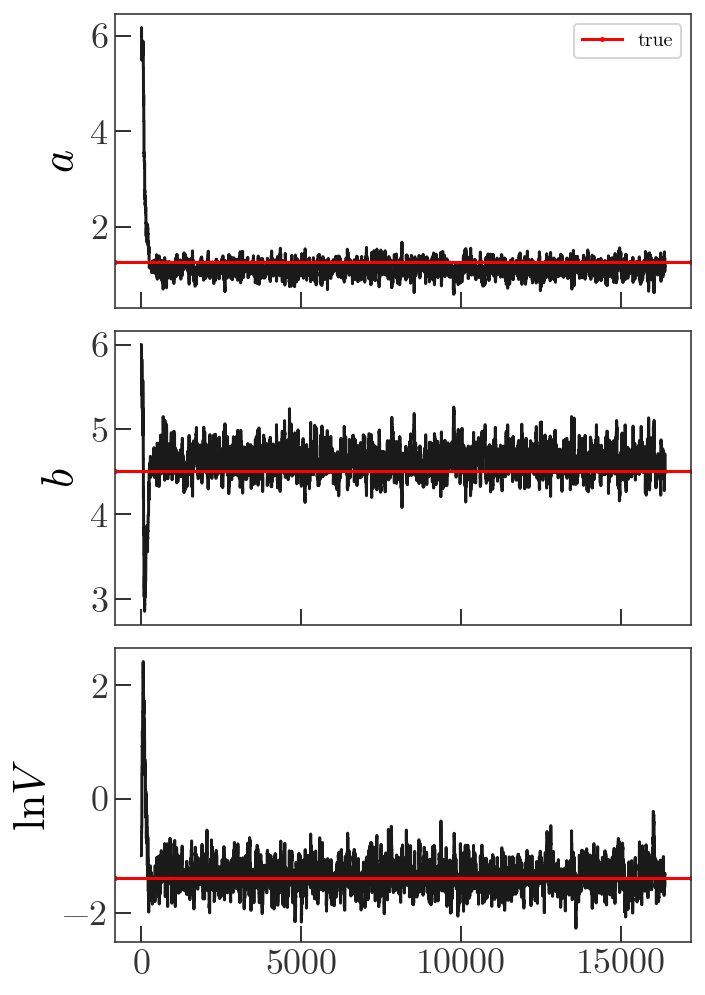

In [188]:
fig,axes = plt.subplots(len(p0), 1, figsize=(5,7), sharex=True)

for i in range(len(p0)):
    axes[i].plot(chain[:,i], marker='', drawstyle='steps')
    
axes[0].axhline(a_true, color='r', label='true')
axes[0].legend(loc='best')
axes[0].set_ylabel('$a$')

axes[1].axhline(b_true, color='r')
axes[1].set_ylabel('$b$')

axes[2].axhline(np.log(V_true), color='r')
axes[2].set_ylabel(r'$\ln V$')

fig.tight_layout()

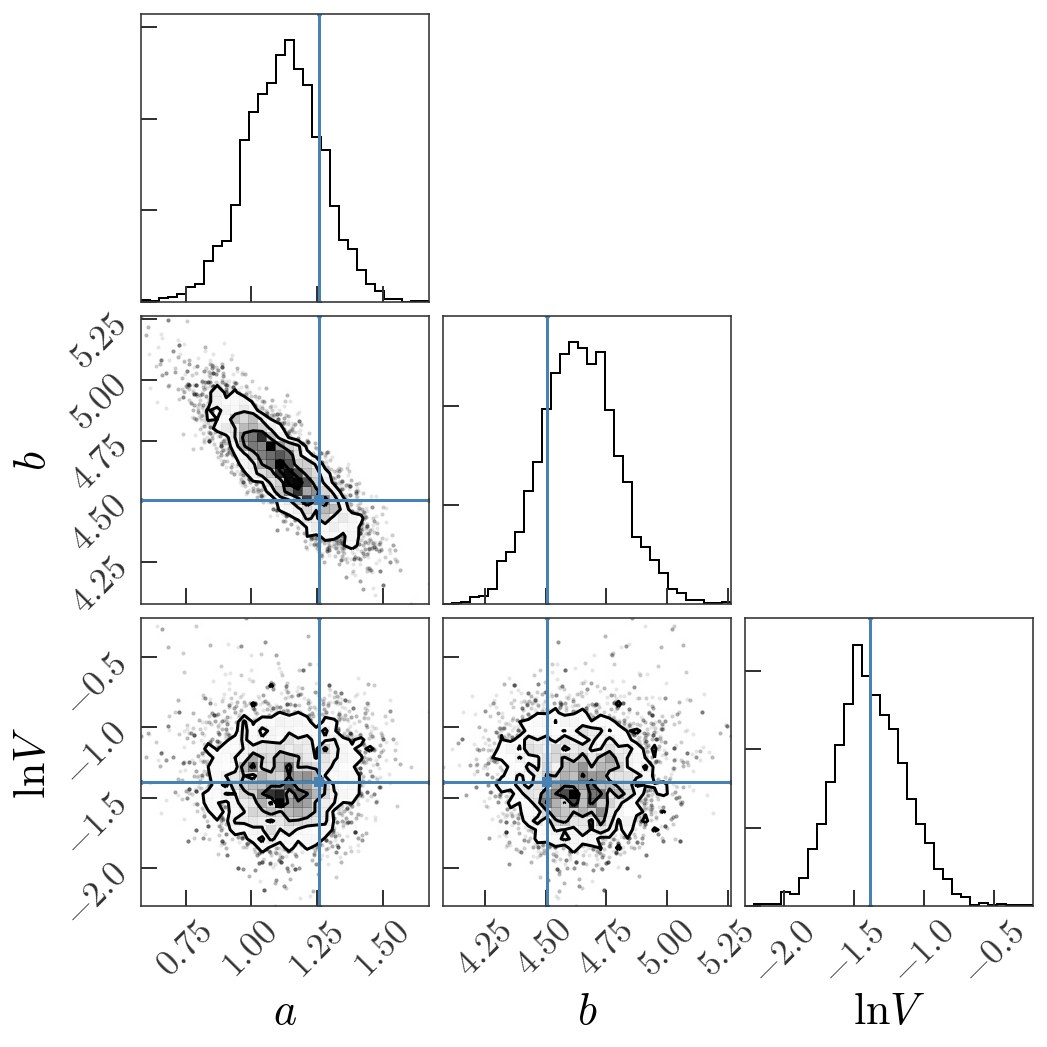

In [189]:
fig = corner.corner(chain[2000:], bins=32, labels=['$a$', '$b$', r'$\ln V$'], 
                    truths=[a_true, b_true, np.log(V_true)])

Now we'll again compute the percentiles for the 1D, marginal distributions:

In [190]:
good_samples = chain[2000::8]
good_samples.shape

(1798, 3)

In [191]:
low,med,hi = np.percentile(good_samples, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str = ""
for i,name in enumerate(['a', 'b', r'ln V']):
    fmt_str = '{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}'
    disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
    disp_str += r'\quad '
    
disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

Compare this to the diagonal elements of the covariance matrix we got from ignoring the intrinsic scatter and doing least-squares fitting:

In [192]:
disp_str = ""
for i,name in zip([1,0], ['a', 'b']):
    fmt_str = r'{name}={val:.2f} \pm {err:.2f}'
    disp_str += fmt_str.format(name=name, val=best_pars[i], err=np.sqrt(pars_Cov[i,i]))
    disp_str += r'\quad '
    
disp_str = "${}$".format(disp_str)
display.Latex(data=disp_str)

<IPython.core.display.Latex object>

The parameter uncertainties estimated from the MCMC samples are much larger -- this reflects our uncertainty about the intrinsic scatter of the points. 

TODO: final exercise?